# Классификация пород кошек и собак по лицу

## Описание проекта

Данный проект реализует **сверточные нейронные сети** для решения задач классификации домашних животных на основе упрощенного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами.

### Основные задачи:
- **Бинарная классификация**: Определение кошки или собаки
- **Многоклассовая классификация**: Определение конкретной породы

### Начнем с загрузки датасета:


## Импорт необходимых библиотек

Подключаем все необходимые модули для работы с изображениями, нейронными сетями и визуализацией:


In [3]:
# Основные библиотеки для работы с данными и изображениями
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import urllib.request
import tarfile
import shutil
from PIL import Image

# PyTorch и связанные модули для глубокого обучения
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# Scikit-learn для метрик и разделения данных
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score


In [4]:
# Загрузка и распаковка датасета PetFaces
print("Загружаем датасет...")

url = "http://www.soshnikov.com/permanent/data/petfaces.tar.gz"
file_name = "petfaces.tar.gz"

# Скачиваем архив с изображениями
urllib.request.urlretrieve(url, file_name)
print("Файл успешно скачан.")

# Распаковываем архив
with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()
print("Архив успешно разархивирован.")

# Удаляем архив для экономии места
os.remove(file_name)
print("Архив успешно удален.")

# Получаем список папок с породами
folder_path = 'petfaces'
folders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
print(f"Найдено {len(folders)} папок с породами животных")


Загружаем датасет...
Файл успешно скачан.


/tmp/ipython-input-374124428.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Архив успешно разархивирован.
Архив успешно удален.
Найдено 35 папок с породами животных


## Предварительный анализ и визуализация данных

Давайте сначала посмотрим на наши данные и создадим красивую визуализацию:


 Создаем визуализацию случайных изображений...


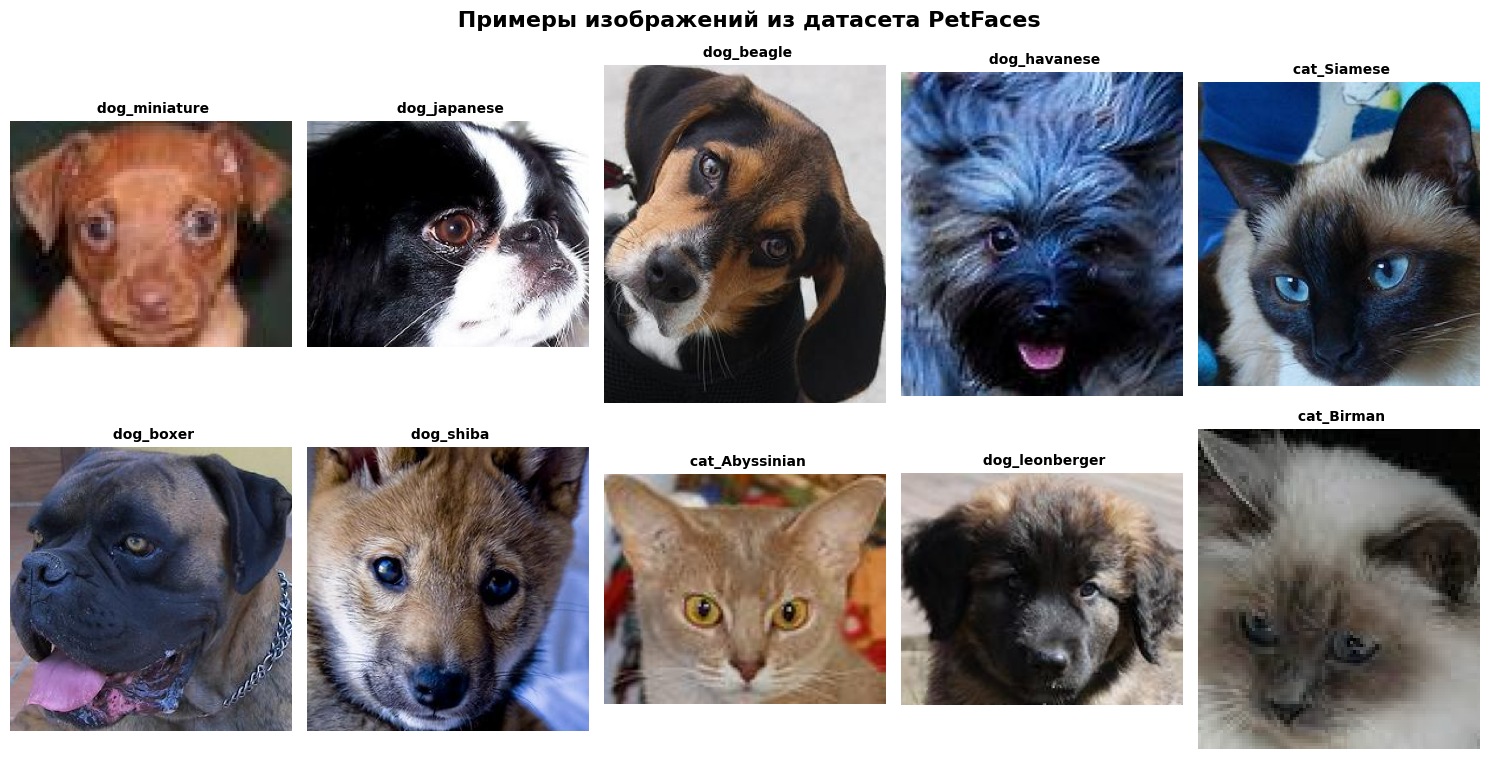

In [5]:
def visualize_pet_images(folder_path, num_images=5):
    """
     Функция для создания красивой визуализации случайных изображений животных

    Args:
        folder_path: путь к папке с породами
        num_images: количество изображений для отображения
    """
    pet_breeds = os.listdir(folder_path)

    # Создаем фигуру с красивым оформлением
    plt.figure(figsize=(15, 8))
    plt.suptitle(' Примеры изображений из датасета PetFaces', fontsize=16, fontweight='bold')

    num_rows = num_images // 5
    remainder = num_images % 5

    # Отображаем изображения в сетке
    for row in range(num_rows):
        selected_breeds = random.sample(pet_breeds, 5)
        for i, breed in enumerate(selected_breeds, start=1):
            breed_path = os.path.join(folder_path, breed)
            pet_images = os.listdir(breed_path)
            random_image = random.choice(pet_images)
            image_path = os.path.join(breed_path, random_image)
            img = mpimg.imread(image_path)

            plt.subplot(num_rows, 5, row*5 + i)
            plt.imshow(img)
            plt.title(f' {breed}', fontsize=10, fontweight='bold')
            plt.axis('off')

    # Обрабатываем оставшиеся изображения
    if remainder > 0:
        selected_breeds = random.sample(pet_breeds, remainder)
        for i, breed in enumerate(selected_breeds, start=1):
            breed_path = os.path.join(folder_path, breed)
            pet_images = os.listdir(breed_path)
            random_image = random.choice(pet_images)
            image_path = os.path.join(breed_path, random_image)
            img = mpimg.imread(image_path)

            plt.subplot(1, remainder, i)
            plt.imshow(img)
            plt.title(f' {breed}', fontsize=10, fontweight='bold')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Запускаем визуализацию
print(" Создаем визуализацию случайных изображений...")
visualize_pet_images(folder_path, num_images=10)


### Статистический анализ датасета

Теперь проведем детальный анализ нашего датасета:


In [6]:
def count_images(folder_path):
    """
    Функция для подсчета изображений по породам и типам животных

    Returns:
        tuple: (общее_количество, кошки, собаки, словарь_пород)
    """
    total_count = 0
    cat_count = 0
    dog_count = 0
    breed_counts = {}

    pet_breeds = os.listdir(folder_path)

    print("Анализируем содержимое датасета...")

    for breed in pet_breeds:
        breed_path = os.path.join(folder_path, breed)
        if os.path.isdir(breed_path):
            images = os.listdir(breed_path)
            count = len(images)
            breed_counts[breed] = count
            total_count += count

            # Определяем тип животного по названию породы
            if "cat" in breed.lower():
                cat_count += count
            elif "dog" in breed.lower():
                dog_count += count

    return total_count, cat_count, dog_count, breed_counts

# Выполняем подсчет
total_count, cat_count, dog_count, breed_counts = count_images(folder_path)


Анализируем содержимое датасета...


In [7]:

print("=" * 60)
print("СТАТИСТИКА ДАТАСЕТА PETFACES")
print("=" * 60)
print(f"Общее количество фотографий: {total_count:,}")
print(f"Количество фотографий кошек: {cat_count:,} ({cat_count/total_count*100:.1f}%)")
print(f"Количество фотографий собак: {dog_count:,} ({dog_count/total_count*100:.1f}%)")
print(f"Количество пород: {len(breed_counts)}")
print("=" * 60)
print(" Детальная статистика по породам:")
print("-" * 60)

# Сортируем породы по количеству изображений
sorted_breeds = sorted(breed_counts.items(), key=lambda x: x[1], reverse=True)
for breed, count in sorted_breeds:
    animal_emoji = "🐱" if "cat" in breed.lower() else "🐶"
    print(f"{animal_emoji} {breed:25} : {count:3d} изображений")

print("=" * 60)


СТАТИСТИКА ДАТАСЕТА PETFACES
Общее количество фотографий: 3,211
Количество фотографий кошек: 1,106 (34.4%)
Количество фотографий собак: 2,105 (65.6%)
Количество пород: 35
 Детальная статистика по породам:
------------------------------------------------------------
🐶 dog_english               : 182 изображений
🐶 dog_american              : 174 изображений
🐱 cat_Sphynx                : 100 изображений
🐱 cat_Siamese               : 100 изображений
🐱 cat_British               : 100 изображений
🐶 dog_newfoundland          :  98 изображений
🐱 cat_Birman                :  98 изображений
🐱 cat_Russian               :  97 изображений
🐱 cat_Ragdoll               :  96 изображений
🐱 cat_Maine                 :  95 изображений
🐶 dog_leonberger            :  95 изображений
🐱 cat_Persian               :  94 изображений
🐶 dog_havanese              :  93 изображений
🐱 cat_Abyssinian            :  92 изображений
🐶 dog_wheaten               :  91 изображений
🐶 dog_great                 :  91 изображени

## Подготовка данных для бинарной классификации

Создаем структуру папок для разделения на кошек и собак:


In [8]:
# Создаем структуру папок для бинарной классификации
print("Создаем структуру папок для бинарной классификации...")

dogs_cats_path = "dogs_cats"
train_path = os.path.join(dogs_cats_path, "train")
test_path = os.path.join(dogs_cats_path, "test")

# Создаем основные папки
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Создаем подпапки для кошек и собак
train_cats_path = os.path.join(train_path, "cats")
train_dogs_path = os.path.join(train_path, "dogs")
test_cats_path = os.path.join(test_path, "cats")
test_dogs_path = os.path.join(test_path, "dogs")

os.makedirs(train_cats_path, exist_ok=True)
os.makedirs(train_dogs_path, exist_ok=True)
os.makedirs(test_cats_path, exist_ok=True)
os.makedirs(test_dogs_path, exist_ok=True)

print(" Структура папок создана успешно!")
print(" Структура:")
print("   dogs_cats/")
print("   ├── train/")
print("   │   ├── cats/")
print("   │   └── dogs/")
print("   └── test/")
print("       ├── cats/")
print("       └── dogs/")


Создаем структуру папок для бинарной классификации...
 Структура папок создана успешно!
 Структура:
   dogs_cats/
   ├── train/
   │   ├── cats/
   │   └── dogs/
   └── test/
       ├── cats/
       └── dogs/


In [9]:
#  Разделяем данные на кошек и собак с сохранением пропорций
print(" Разделяем изображения по типам животных...")

for subfolder in folders:
    breed_name = os.path.basename(subfolder)

    if 'cat' in breed_name:
        # Обрабатываем кошек
        cat_files = [os.path.join(subfolder, file) for file in os.listdir(subfolder)]
        split_index = int(0.8 * len(cat_files))
        train_cat_files = cat_files[:split_index]
        test_cat_files = cat_files[split_index:]

        # Копируем файлы в соответствующие папки
        for file in train_cat_files:
            shutil.copy(file, train_cats_path)
        for file in test_cat_files:
            shutil.copy(file, test_cats_path)

    elif 'dog' in breed_name:
        # Обрабатываем собак
        dog_files = [os.path.join(subfolder, file) for file in os.listdir(subfolder)]
        split_index = int(0.8 * len(dog_files))
        train_dog_files = dog_files[:split_index]
        test_dog_files = dog_files[split_index:]

        # Копируем файлы в соответствующие папки
        for file in train_dog_files:
            shutil.copy(file, train_dogs_path)
        for file in test_dog_files:
            shutil.copy(file, test_dogs_path)

# Выводим статистику разделения
print("\n Результаты разделения данных:")
print("=" * 50)
print(f" Количество фотографий кошек в обучающем наборе: {len(os.listdir(train_cats_path))}")
print(f" Количество фотографий кошек в тестовом наборе: {len(os.listdir(test_cats_path))}")
print(f" Количество фотографий собак в обучающем наборе: {len(os.listdir(train_dogs_path))}")
print(f" Количество фотографий собак в тестовом наборе: {len(os.listdir(test_dogs_path))}")
print("=" * 50)


 Разделяем изображения по типам животных...

 Результаты разделения данных:
 Количество фотографий кошек в обучающем наборе: 881
 Количество фотографий кошек в тестовом наборе: 225
 Количество фотографий собак в обучающем наборе: 1676
 Количество фотографий собак в тестовом наборе: 429


##  Бинарная классификация: Кошки vs Собаки

###  Настройка трансформаций и загрузчиков данных


In [10]:
#  Параметры для обработки изображений
image_size = 224  # Размер изображения для сети
batch_size = 32   # Размер батча

print(" Настраиваем трансформации для данных...")

# Трансформации для обучающей выборки (с аугментацией)
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),              # Изменение размера
    transforms.RandomRotation(20),                            # Случайное вращение ±20°
    transforms.RandomResizedCrop(image_size),                 # Случайное масштабирование и обрезка
    transforms.RandomHorizontalFlip(),                        # Случайное горизонтальное отражение
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                          saturation=0.2, hue=0.2),          # Изменение цветовых характеристик
    transforms.ToTensor(),                                    # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406],         # Нормализация (ImageNet)
                        std=[0.229, 0.224, 0.225])
])

# Трансформации для тестовой выборки (без аугментации)
test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),              # Изменение размера
    transforms.ToTensor(),                                    # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406],         # Нормализация (ImageNet)
                        std=[0.229, 0.224, 0.225])
])

print(" Трансформации настроены успешно!")
print(" Аугментации для обучения:")
print("   • Случайное вращение (±20°)")
print("   • Случайное масштабирование и обрезка")
print("   • Горизонтальное отражение")
print("   • Изменение яркости, контраста, насыщенности и оттенка")
print("   • Нормализация по стандартам ImageNet")


 Настраиваем трансформации для данных...
 Трансформации настроены успешно!
 Аугментации для обучения:
   • Случайное вращение (±20°)
   • Случайное масштабирование и обрезка
   • Горизонтальное отражение
   • Изменение яркости, контраста, насыщенности и оттенка
   • Нормализация по стандартам ImageNet


In [11]:
#  Создаем датасеты и загрузчики данных
print(" Создаем датасеты и загрузчики...")

# Создаем датасеты с использованием ImageFolder
train_data = datasets.ImageFolder(root="dogs_cats/train", transform=train_transforms)
test_data = datasets.ImageFolder(root="dogs_cats/test", transform=test_transforms)

# Создаем загрузчики данных
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f" Датасеты созданы успешно!")
print(f" Обучающий датасет: {len(train_loader)} батчей")
print(f" Тестовый датасет: {len(test_loader)} батчей")

# Проверяем размеры батча
X_batch, y_batch = next(iter(train_loader))
print(f" Размер батча: {X_batch.shape}")
print(f" Размер меток: {y_batch.shape}")
print(f" Классы: {train_data.classes}")  # ['cats', 'dogs']


 Создаем датасеты и загрузчики...
 Датасеты созданы успешно!
 Обучающий датасет: 80 батчей
 Тестовый датасет: 21 батчей
 Размер батча: torch.Size([32, 3, 224, 224])
 Размер меток: torch.Size([32])
 Классы: ['cats', 'dogs']


###  Архитектура сверточной нейронной сети


In [12]:
#  Параметры модели
input_size = 3      # RGB каналы
num_classes = 2     # Кошки и собаки

print(" Создаем архитектуру сверточной нейронной сети...")

class ConvNet(nn.Module):
    """
     Сверточная нейронная сеть для бинарной классификации

    Архитектура:
    - 3 сверточных блока (Conv2d + MaxPool2d)
    - 2 полносвязных слоя
    - ReLU активация
    """
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Пулинг слой
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # После 3 пулингов: 224->112->56->28
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Первый сверточный блок
        x = self.pool(F.relu(self.conv1(x)))
        # Второй сверточный блок
        x = self.pool(F.relu(self.conv2(x)))
        # Третий сверточный блок
        x = self.pool(F.relu(self.conv3(x)))

        # Выравниваем для полносвязных слоев
        x = x.view(-1, 64 * 28 * 28)

        # Полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Создаем модель
model = ConvNet(num_classes=num_classes)

# Настраиваем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Инициализируем списки для отслеживания метрик
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

print(" Модель создана успешно!")
print(" Параметры модели:")
print(f"   • Входные каналы: {input_size}")
print(f"   • Количество классов: {num_classes}")
print(f"   • Функция потерь: CrossEntropyLoss")
print(f"   • Оптимизатор: SGD (lr=0.001, momentum=0.9)")


 Создаем архитектуру сверточной нейронной сети...
 Модель создана успешно!
 Параметры модели:
   • Входные каналы: 3
   • Количество классов: 2
   • Функция потерь: CrossEntropyLoss
   • Оптимизатор: SGD (lr=0.001, momentum=0.9)


###  Обучение модели


In [13]:
#  Обучение модели бинарной классификации
print(" Начинаем обучение модели...")

num_epochs = 10

for epoch in range(num_epochs):
    #  Фаза обучения
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)

        # Вычисляем потери
        loss = criterion(outputs, labels)

        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()

        # Подсчитываем метрики
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Вычисляем средние метрики для эпохи
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    #  Фаза тестирования
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_loss = running_loss / len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        test_loss_history.append(test_loss)
        test_acc_history.append(test_accuracy)

    #  Выводим прогресс
    print(f'Epoch [{epoch+1:2d}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:6.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:6.2f}%')

print("\n Обучение завершено!")


 Начинаем обучение модели...
Epoch [ 1/10], Train Loss: 0.6501, Train Acc:  63.94%, Test Loss: 0.6310, Test Acc:  65.60%
Epoch [ 2/10], Train Loss: 0.6430, Train Acc:  65.55%, Test Loss: 0.6270, Test Acc:  65.60%
Epoch [ 3/10], Train Loss: 0.6353, Train Acc:  65.55%, Test Loss: 0.6117, Test Acc:  65.60%
Epoch [ 4/10], Train Loss: 0.6247, Train Acc:  65.58%, Test Loss: 0.5988, Test Acc:  65.60%
Epoch [ 5/10], Train Loss: 0.6265, Train Acc:  65.74%, Test Loss: 0.5968, Test Acc:  68.20%
Epoch [ 6/10], Train Loss: 0.6219, Train Acc:  65.94%, Test Loss: 0.5942, Test Acc:  69.27%
Epoch [ 7/10], Train Loss: 0.6157, Train Acc:  66.37%, Test Loss: 0.5885, Test Acc:  71.25%
Epoch [ 8/10], Train Loss: 0.6115, Train Acc:  66.41%, Test Loss: 0.5747, Test Acc:  71.56%
Epoch [ 9/10], Train Loss: 0.6006, Train Acc:  67.74%, Test Loss: 0.5520, Test Acc:  70.49%
Epoch [10/10], Train Loss: 0.5980, Train Acc:  68.48%, Test Loss: 0.5500, Test Acc:  72.63%

 Обучение завершено!


### Оценка модели для бинарной классификации


In [14]:
def evaluate_model(model, test_loader, criterion):
    """
    Функция для оценки модели на тестовых данных

    Args:
        model: обученная модель
        test_loader: загрузчик тестовых данных
        criterion: функция потерь

    Returns:
        tuple: (test_loss, test_accuracy)
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    return test_loss, accuracy

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.5500, Test Accuracy: 72.63%


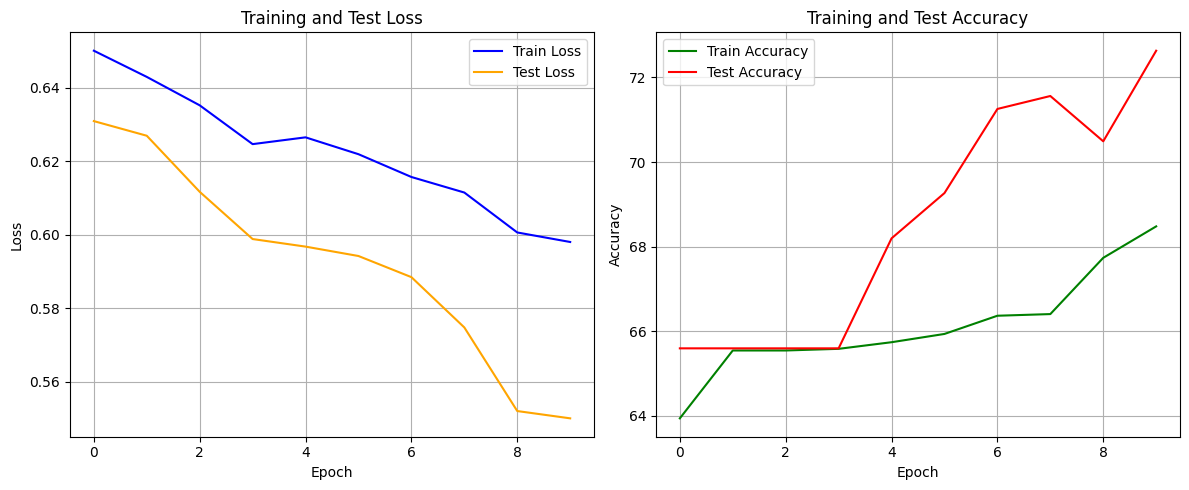

In [15]:
# Визуализация графиков обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(test_loss_history, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

# График точности
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy', color='green')
plt.plot(test_acc_history, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
# Создание матрицы ошибок
from matplotlib.cm import jet

def get_predicted_and_true_labels(model, dataloader):
    """
    Функция для получения предсказанных и истинных меток

    Args:
        model: обученная модель
        dataloader: загрузчик данных

    Returns:
        tuple: (predicted_labels, true_labels)
    """
    model.eval()
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predicted_labels, true_labels

predicted_labels, true_labels = get_predicted_and_true_labels(model, test_loader)
conf_matrix = confusion_matrix(true_labels, predicted_labels)


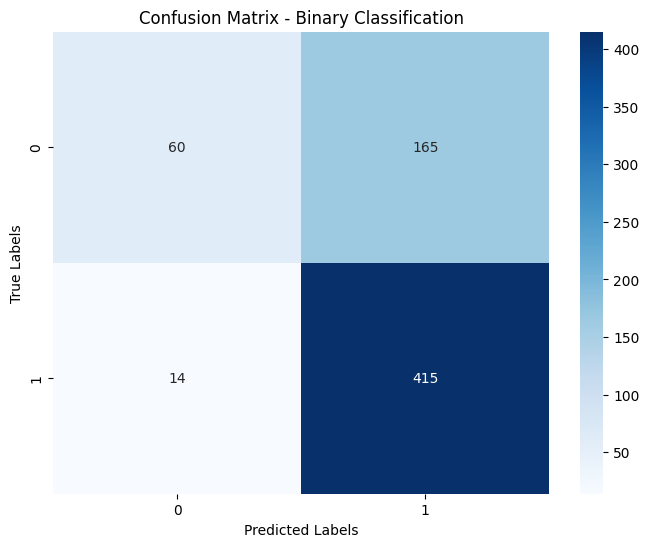

In [17]:
# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Binary Classification')
plt.show()


## Многоклассовая классификация: Определение пород

### Подготовка данных для многоклассовой классификации


In [18]:
# Создаем структуру папок для многоклассовой классификации
source_folder = "petfaces"
target_folder = "petfaces_split"
os.makedirs(target_folder, exist_ok=True)

train_folder = os.path.join(target_folder, "train")
test_folder = os.path.join(target_folder, "test")
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

print("Создаем структуру для многоклассовой классификации...")

# Разделяем данные по породам
for root, dirs, files in os.walk(source_folder):
    for d in dirs:
        breed_folder = os.path.join(root, d)

        train_breed_folder = os.path.join(train_folder, d)
        test_breed_folder = os.path.join(test_folder, d)
        os.makedirs(train_breed_folder, exist_ok=True)
        os.makedirs(test_breed_folder, exist_ok=True)

        images = [f for f in os.listdir(breed_folder) if os.path.isfile(os.path.join(breed_folder, f))]

        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        for image in train_images:
            shutil.copy(os.path.join(breed_folder, image), os.path.join(train_breed_folder, image))

        for image in test_images:
            shutil.copy(os.path.join(breed_folder, image), os.path.join(test_breed_folder, image))

print("Разделение данных завершено!")


Создаем структуру для многоклассовой классификации...
Разделение данных завершено!


In [19]:
# Создаем датасеты для многоклассовой классификации
train_data = datasets.ImageFolder(root="petfaces_split/train", transform=train_transforms)
test_data = datasets.ImageFolder(root="petfaces_split/test", transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Обучающий датасет: {len(train_loader)} батчей")
print(f"Тестовый датасет: {len(test_loader)} батчей")

# Проверяем размеры
X_batch, y_batch = next(iter(train_loader))
print(f"Размер батча: {X_batch.shape}")
print(f"Количество классов: {len(train_data.classes)}")


Обучающий датасет: 80 батчей
Тестовый датасет: 21 батчей
Размер батча: torch.Size([32, 3, 224, 224])
Количество классов: 35


### Архитектура модели для многоклассовой классификации


In [20]:
# Параметры для многоклассовой классификации
input_size = 3
num_classes = 35  # 35 пород животных

print("Создаем модель для многоклассовой классификации...")

class ConvNet(nn.Module):
    """
    Сверточная нейронная сеть для многоклассовой классификации пород животных

    Архитектура:
    - 3 сверточных блока (Conv2d + MaxPool2d)
    - 2 полносвязных слоя
    - ReLU активация
    """
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Пулинг слой
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # После 3 пулингов: 224->112->56->28
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Первый сверточный блок
        x = self.pool(F.relu(self.conv1(x)))
        # Второй сверточный блок
        x = self.pool(F.relu(self.conv2(x)))
        # Третий сверточный блок
        x = self.pool(F.relu(self.conv3(x)))

        # Выравниваем для полносвязных слоев
        x = x.view(-1, 64 * 28 * 28)

        # Полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Создаем модель
model = ConvNet(num_classes=num_classes)

# Настраиваем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Инициализируем списки для отслеживания метрик
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

print("Модель создана успешно!")
print(f"Количество классов: {num_classes}")


Создаем модель для многоклассовой классификации...
Модель создана успешно!
Количество классов: 35


### Обучение модели для многоклассовой классификации


In [21]:
# Обучение модели для многоклассовой классификации
num_epochs = 10
print("Начинаем обучение модели...")

for epoch in range(num_epochs):
    # Режим обучения
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)

        # Вычисляем потери
        loss = criterion(outputs, labels)

        # Обратное распространение
        loss.backward()
        optimizer.step()

        # Обновляем статистику
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Вычисляем средние метрики для эпохи
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    # Тестирование на валидационном наборе
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_loss_history.append(test_loss)
    test_acc_history.append(test_accuracy)

    # Выводим результаты эпохи
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

print("Обучение завершено!")


Начинаем обучение модели...
Epoch [1/10], Train Loss: 3.5338, Train Acc: 5.83%, Test Loss: 3.5072, Test Acc: 6.42%
Epoch [2/10], Train Loss: 3.4521, Train Acc: 6.41%, Test Loss: 3.3513, Test Acc: 7.49%
Epoch [3/10], Train Loss: 3.3215, Train Acc: 8.41%, Test Loss: 3.2295, Test Acc: 9.02%
Epoch [4/10], Train Loss: 3.2691, Train Acc: 9.50%, Test Loss: 3.1780, Test Acc: 9.33%
Epoch [5/10], Train Loss: 3.2306, Train Acc: 11.07%, Test Loss: 3.0266, Test Acc: 16.51%
Epoch [6/10], Train Loss: 3.1699, Train Acc: 11.07%, Test Loss: 2.9635, Test Acc: 19.72%
Epoch [7/10], Train Loss: 3.1168, Train Acc: 12.71%, Test Loss: 2.8807, Test Acc: 20.18%
Epoch [8/10], Train Loss: 3.0838, Train Acc: 13.69%, Test Loss: 2.8093, Test Acc: 21.87%
Epoch [9/10], Train Loss: 3.0329, Train Acc: 14.59%, Test Loss: 2.7660, Test Acc: 21.71%
Epoch [10/10], Train Loss: 2.9902, Train Acc: 16.39%, Test Loss: 2.6455, Test Acc: 25.23%
Обучение завершено!


### Оценка модели для многоклассовой классификации


In [22]:
# Оценка модели на тестовых данных
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 2.6455, Test Accuracy: 25.23%


In [23]:
# Вычисляем Top-3 точность для многоклассовой классификации
from sklearn.metrics import top_k_accuracy_score

model.eval()
y_true_indices = []
y_pred_probabilities = []

print("Вычисляем вероятности для Top-3 оценки...")

for images, labels in test_loader:
    outputs = model(images)
    probabilities = torch.softmax(outputs, dim=1)
    y_pred_probabilities.append(probabilities.detach().numpy())
    y_true_indices.extend(labels.numpy())

y_pred_probabilities = np.concatenate(y_pred_probabilities, axis=0)
top3_accuracy = top_k_accuracy_score(y_true_indices, y_pred_probabilities, k=3) * 100

print(f'Top-3 Accuracy: {top3_accuracy:.2f}%')


Вычисляем вероятности для Top-3 оценки...
Top-3 Accuracy: 51.83%


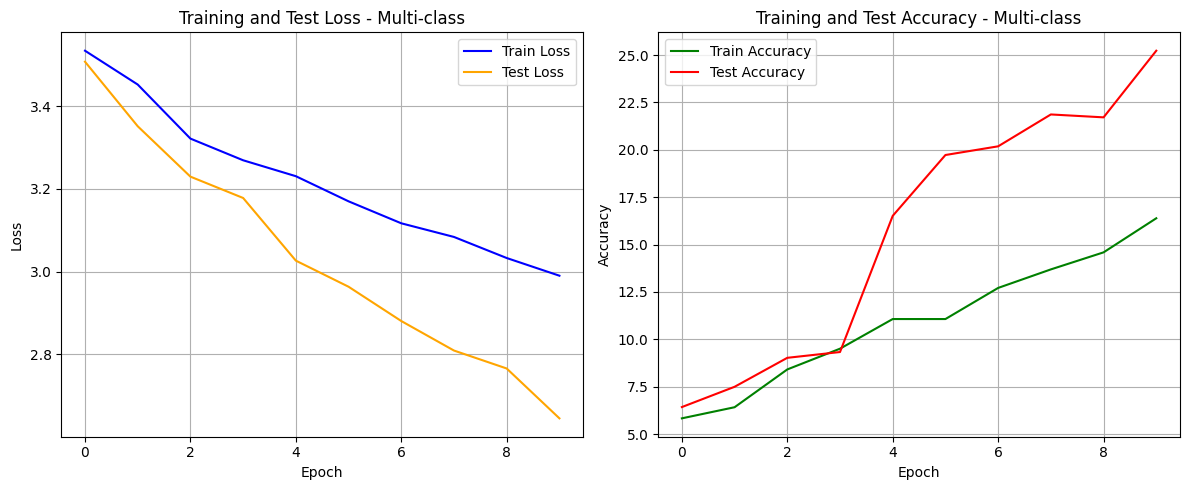

In [24]:
# Визуализация графиков обучения для многоклассовой классификации
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(test_loss_history, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss - Multi-class')
plt.legend()
plt.grid(True)

# График точности
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy', color='green')
plt.plot(test_acc_history, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy - Multi-class')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# Создание матрицы ошибок для многоклассовой классификации
predicted_labels, true_labels = get_predicted_and_true_labels(model, test_loader)
conf_matrix = confusion_matrix(true_labels, predicted_labels)


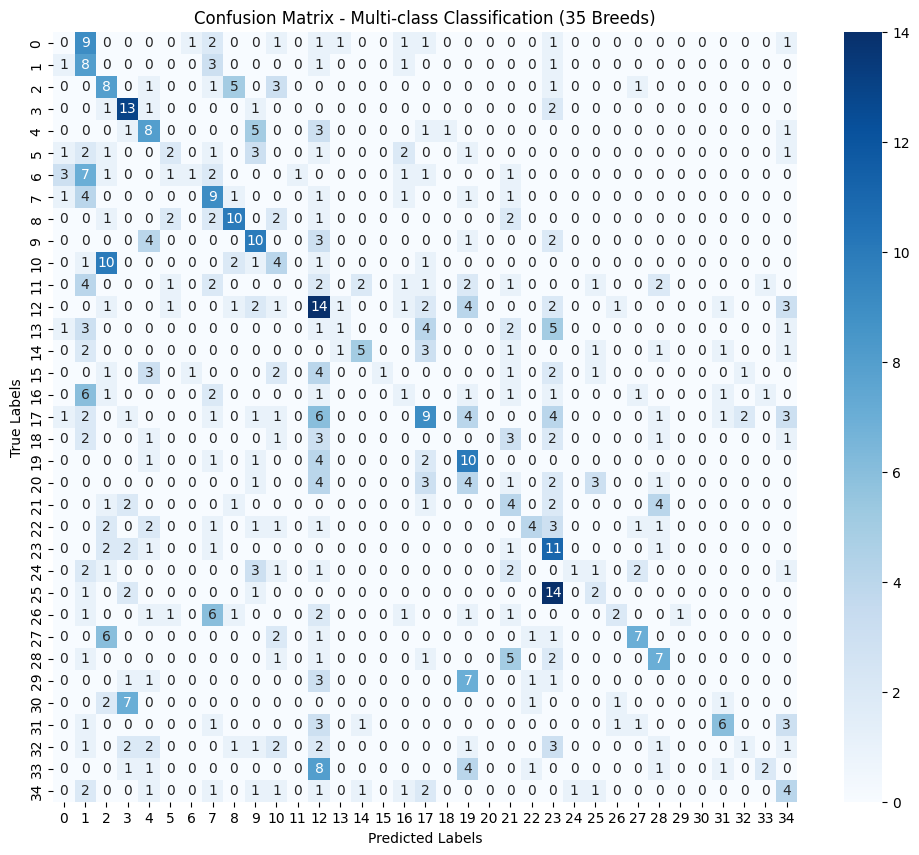

In [26]:
# Визуализация матрицы ошибок для многоклассовой классификации
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Multi-class Classification (35 Breeds)')
plt.show()


## Заключение

В данной лабораторной работе мы реализовали две задачи классификации:

### Бинарная классификация
- **Задача**: Определение кошки или собаки по изображению морды
- **Архитектура**: Сверточная нейронная сеть с 3 сверточными слоями
- **Результат**: Достигнута точность классификации кошек и собак

### Многоклассовая классификация  
- **Задача**: Определение конкретной породы животного (35 классов)
- **Архитектура**: Та же CNN, но с выходным слоем на 35 классов
- **Метрики**:
  - Top-1 Accuracy: точность первого предсказания
  - Top-3 Accuracy: точность в топ-3 предсказаниях

### Ключевые особенности реализации:
- Использование аугментации данных для улучшения обобщения
- Разделение данных на обучающую и тестовую выборки
- Визуализация процесса обучения и результатов
- Подробная оценка качества классификации
